In [131]:
from xml.dom import minidom
import re
import pandas as pd
import sys
import pickle
import numpy as np
sys.__stdout__=sys.stdout
TAG_RE = re.compile(r'<[^>]+>')
def remove_tags(text):
    text=re.sub('\n',' ',text)
    #text=re.sub('-',' ',text)
    text=re.sub('[\'"]','',text)
    #text=re.sub('[()?.@*#&!,$]','',text)
    text=re.sub('[^a-z0-9]',' ',text)
    return TAG_RE.sub('', text)

def make_dictionary(topics,max_doc,root):
    index=0
    wordmap={}
    word_count=[]
    for topic in topics:
        print(topic)
        mydoc = minidom.parse(root+topic+'.xml')
        docs = mydoc.getElementsByTagName('row')
        doc_count=0
        for doc in docs:
            if doc_count>=max_doc:
                break
            doc=doc.attributes['Body'].value
            doc=doc.lower()
            doc = remove_tags(doc)
            words=doc.split(' ')
            for word in words:
                if word in s_words:
                    continue
                if word not in wordmap:
                    wordmap[word]=index
                    word_count.append(int(1))
                    index=index+1
                elif word in wordmap:
                    ind=wordmap[word]
                    word_count[ind]=int(word_count[ind])+1
            doc_count=doc_count+1
    return wordmap,word_count


In [151]:
def vectorize_seq_nb(topics,max_doc,wordmap,root,doc_per_vect='all'):
    if doc_per_vect=='single':
        n_row=len(topics)*(max_doc)
    if doc_per_vect=='all':
        n_row=len(topics)
    vectors=np.zeros((n_row,len(wordmap)),dtype=np.float64)
    vct_label=[]
    row=0
    alpha=1
    _V=len(wordmap)
    for topic in topics:
        print(topic)
        mydoc = minidom.parse(root+topic+'.xml')
        docs = mydoc.getElementsByTagName('row')
        doc_count=0
        for doc in docs:
            if doc_count>=max_doc:
                break
            #vector = [0]*(len(wordmap)+2)
            doc=doc.attributes['Body'].value
            doc=doc.lower()
            doc = remove_tags(doc)
            words=doc.split(' ')
                     
            if len(words)<5:
                continue
            for word in words:
                if word in wordmap:
                    ind=wordmap[word]
                    vectors[row,ind]=vectors[row,ind]+1
            doc_count=doc_count+1
            word_list.append(words)
            if doc_per_vect=='single':
                row=row+1
                vct_label.append(topic)
        if doc_per_vect=='all':
            vct_label.append(topic)
            total=np.sum(vectors[row])
            vectors[row]=(vectors[row]+alpha)/(total+alpha*_V)
            row=row+1
    return vectors,vct_label

In [152]:
root='Dataset/Training/'
root_test='Dataset/Test/'
f=open('Stopwords.txt')
s_words=f.read()
s_words=s_words.split('\n')
s_words.append('')

topics=['3d_Printer','Coffee','Arduino','Astronomy','Biology']#,'Chess','Cooking','Law','Space','Windows_Phone','Wood_Working']
#topics=['Anime']


 
#wordmap=make_dictionary(topics,100,root)
#vectors=vectorize_seq(topics,100,wordmap,root)
word_list=[]
write_backup=1
if write_backup==1:
    wordmap,wc=make_dictionary(topics,500,root)
    vectors,vct_labels=vectorize_seq_nb(topics,500,wordmap,root)
    pickle_out = open("wordmap_test.pickle","wb")
    pickle.dump(wordmap, pickle_out)
    pickle_out.close()
    pickle_out = open("vectors_test.pickle","wb")
    pickle.dump(vectors, pickle_out)
    pickle_out.close()

read_backup=0
if read_backup==1:
    print('Reading backup')
    pickle_read = open("wordmap_500.pickle","rb")
    wordmap=pickle.load(pickle_read)
    pickle_read.close()

    pickle_read = open("vectors_500.pickle","rb")
    vectors=pickle.load(pickle_read)
    pickle_read.close()

#words=list(wordmap.keys())
#freq=list(wordmap.values())
#word_df=pd.DataFrame({'words':words,'freq':freq})
#word_df=word_df.sort_values('freq',ascending=False)
    



3d_Printer
Coffee
Arduino
Astronomy
Biology
3d_Printer
Coffee
Arduino
Astronomy
Biology


[  2.34879624e-03   7.76618112e-04   2.46244767e-04 ...,   1.89419052e-05
   1.89419052e-05   1.89419052e-05]


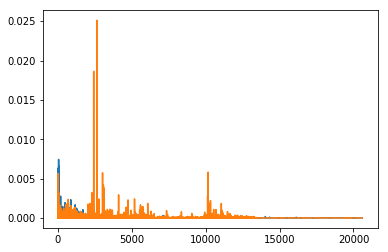

['3d_Printer', 'Coffee', 'Arduino', 'Astronomy', 'Biology']


In [153]:
from matplotlib import pyplot as plt
print((vectors[0]))
x=range(len(vectors[0]))
plt.plot(x,vectors[0])
plt.plot(x,vectors[2])
#plt.plot(x,vectors[2])
plt.show()
print(vct_labels)

In [154]:
#print(word_list)
d=np.array([1,2,3,4,5,6])
print(d)
k=d.copy()
k[k==3]=100
print(d,k)
tv=vectors
a=vectors[0,:]
#print(len())
print(np.array([k==2],dtype=np.uint8))

[1 2 3 4 5 6]
[1 2 3 4 5 6] [  1   2 100   4   5   6]
[[0 1 0 0 0 0]]


In [158]:
test_vectors,true_lbs=vectorize_seq_nb(topics,5,wordmap,root_test,doc_per_vect='single')
def nb(test_vector,vector,vct_labels):
    probs=[]
    maxm=0
    lb=''
    prob=0
    vct=0
    for i in range(len(vector)):
        vct=vector[i,:].copy()
        vct[test_vector==0]=1
        #vct=vct*np.array([test_vector==0],dtype=np.uint8) 
        #vct=vct+np.array([vct==0],dtype=np.uint8) 
        #vct=vct*[test_vector>0]
        prob=np.prod(vct)
        probs.append(prob)
        if prob>maxm:
            maxm=prob
            lb=vct_labels[i]
    return probs,lb
print(len(test_vectors[0]))

3d_Printer
Coffee
Arduino
Astronomy
Biology
20599


In [159]:
print(true_lbs)

['3d_Printer', '3d_Printer', '3d_Printer', '3d_Printer', '3d_Printer', 'Coffee', 'Coffee', 'Coffee', 'Coffee', 'Coffee', 'Arduino', 'Arduino', 'Arduino', 'Arduino', 'Arduino', 'Astronomy', 'Astronomy', 'Astronomy', 'Astronomy', 'Astronomy', 'Biology', 'Biology', 'Biology', 'Biology', 'Biology']


In [160]:
acc=0
for i in range(len(test_vectors)):
    pred,lb=nb(test_vectors[i],tv,vct_labels)
    if lb==true_lbs[i]:
        acc=acc+1
    print('res','pred',lb,'true',true_lbs[i],i+1,acc)
    #print(pred)

res pred 3d_Printer true 3d_Printer 1 1
res pred 3d_Printer true 3d_Printer 2 2
res pred 3d_Printer true 3d_Printer 3 3
res pred 3d_Printer true 3d_Printer 4 4
res pred 3d_Printer true 3d_Printer 5 5
res pred Coffee true Coffee 6 6
res pred  true Coffee 7 6
res pred Coffee true Coffee 8 7
res pred Coffee true Coffee 9 8
res pred Coffee true Coffee 10 9
res pred Arduino true Arduino 11 10
res pred Arduino true Arduino 12 11
res pred Arduino true Arduino 13 12
res pred Arduino true Arduino 14 13
res pred  true Arduino 15 13
res pred Astronomy true Astronomy 16 14
res pred Astronomy true Astronomy 17 15
res pred Astronomy true Astronomy 18 16
res pred Astronomy true Astronomy 19 17
res pred  true Astronomy 20 17
res pred Astronomy true Biology 21 17
res pred Biology true Biology 22 18
res pred Biology true Biology 23 19
res pred Coffee true Biology 24 19
res pred Biology true Biology 25 20


In [98]:
np.float64(1.1046088816626036e-352*10)

0.0

In [61]:
words=list(wordmap.keys())
freq=list(wordmap.values())
word_df=pd.DataFrame(words,index=list(wordmap.values()))
word_df=word_df.sort_index()
word_df['freq']=wc
word_df=word_df.sort_values('freq',ascending=False)
print(word_df[0:50])
#print(len(vectors))

                0  freq
2639         code  2860
9             use  1865
5706       coffee  1733
704    blockquote  1344
48           time  1228
2421      arduino  1142
569           way   950
392         space   862
97      questions   803
319          good   726
449         water   702
2781          amp   673
99      different   656
15             im   644
3077        board   643
150          work   631
1065     question   623
514          wood   623
1305           ol   622
12021       phone   614
1893          law   601
3020          pre   589
1166        stack   582
198          long   563
1167        imgur   533
332          case   522
1169          img   516
2919        chess   473
670           bit   462
2310         data   457
3184        black   456
47          print   451
1705            s   448
1274       answer   441
1497        think   440
529        really   431
172        better   426
3973        earth   425
3048        power   414
120         small   411
270      probabl

In [62]:
def knn(nn,test_vect,vectors,vct_labels):
    print('getting h dist')
    #h_dists=eucl_dis(test_vect,vectors,vct_labels)
    #h_dists=humm_dis(test_vect,vectors,vct_labels)
    h_dists=cos_dis(test_vect,vectors,vct_labels)
    h_df=pd.DataFrame(h_dists,columns=['dist','label'])
    h_df=h_df.sort_values('dist',ascending=False)
    lb=h_df['label']
    lb=lb[:nn]
    lb=lb.mode()
    lb=lb.values[0]
    return(lb)
max_doc=60
test_vector,true_lbs=vectorize_seq(topics,max_doc,wordmap,root_test)
acc=0
n=len(topics)*max_doc
for i in range(n):
    true_lb=true_lbs[i]
    test_vect=test_vector[i,:]
    pred_lb=knn(3,test_vect,vectors,vct_labels)
    print(pred_lb,true_lb)
    if pred_lb==true_lb:
        acc=acc+1
        print(pred_lb,true_lb,acc,i)
accuracy=acc/(n)
print('accuray',accuracy)
#68.75% eucl 60 82.92
#53.33 humm 60  66.25
#87.08 cos 94.17

3d_Printer
Coffee
Arduino
Astronomy
Biology
Chess


ExpatError: junk after document element: line 2, column 2

In [ ]:
print(len(test_vector))
print(len(true_lbs))

In [ ]:
from matplotlib import pyplot as plt
vct=[vectors[12][:500]]
test=vectors[15][:498]
dis=eucl_dis(test,vct)
print(vct)
print(test)
print(dis[0][0])
x=range(0,500)
xt=range(0,498)
plt.plot(x,vct[0],xt,test)
plt.show

In [268]:
def eucl_dis(test_vector,vectors):
    h_dists=[]
    for vector in vectors:
        vect=np.array(vector[:-2])
        vect[vect>1]=1
        label=vector[-1]
        test_vect=np.array(test_vector)
        dist=np.abs(vect-test_vect)
        #dist=np.sum(dist)
        h_dists.append([dist,label])
    return h_dists
test_vector=vectors[0][:-2]
vecto=[vectors[0],vectors[1]]
h_dists=cos_dis(test_vector,vecto)
#h_df=pd.DataFrame(h_dists)
#h_df=h_df.sort_values(0)
print(h_dists)
#print((vectors[15]))

[[0.0, 'Coffee'], [4.1408162514693805, 'Coffee']]


In [288]:
for i in range(len(vectors)):
    vct=vectors[i][:-2]
    if np.sum(vct)==0:
        break
print(i,word_list[185])

186 ['does', 'coffee', 'aroma', 'have', 'a', 'detering', 'effect', 'on', 'some', 'insects', 'like', 'flies', 'mosquitos', 'etc', '', 'are', 'there', 'any', 'researches', 'on', 'how', 'the', 'house', 'insects', 'are', 'reacting', 'on', 'coffee', 'aroma', '']


In [109]:
raw='I am hasib\n,i "am" a student() so? @i do& my-duties! porp. and' 
#text=re.sub('\n',' ',raw)
text=raw.lower()
text=re.sub('[^a-z0-9]',' ',text)
#text=re.sub('-',' ',text)
#text=re.sub('[\'"]','',text)
#text=re.sub('[()?.@*#&!,$+]','',text)
#print(text.split(' '))